<a href="https://colab.research.google.com/github/t-perniola/Denoising-Autoencoders-for-GRBs-detection/blob/main/Denoising_Autoencoder_for_GRBs_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving noise management in Autoencoders for Gamma Ray Burst (GRBs) detection

This project would focus on accounting for uncertainty and noise in autoencoders used for
Gamma Ray Burst (GRB) detection. The detection problem is framed as an anomaly
detection task over time series, which can be tackled by training an Autoencoder model on
background data (i.e. signals containing no GRB) and then using the reconstruction error as
a measure of the chance that a new sequence contains a notable event (such as a GRB).
Well performing models have already been trained, but they are suboptimal in how they
account for output noise, and they do not account explicitly for input noise. The goal is to
devise methods (e.g. neuro-probabilistic models) to account for uncertainty, so as to obtain
more reliable results.

## **Importing** useful libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import tensorflow as tf
from scipy.stats import skewnorm
from utils import *

## Let's **generate** our **syntethic** data

### Ensuring reproducibility
**Todo**: to also ensure robustness, we should iterate the process below over different seeds

In [2]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### **Training** data

We assume our data follows a **Skew-Normal** distribution, which is a simplification given that our data consists of multiple overlapping signals. Specifically, the original **background** signal is the sum of various components, including noise, external sources, etc. For now, we will use this as a **baseline**.

In [3]:
alpha_fit = 1.52731191e+00
mu_fit = 6.17068919e+01
sigma_fit = 1.70926014e+01
num_samples = 10000  # Numero di punti della time series da generare

def generate_skewnorm_data(alpha, mu, sigma, num_samples): # size: num of distribution to output
  data = skewnorm.rvs(alpha_fit, loc=mu_fit, scale=sigma_fit, size=num_samples, random_state=42)
  return data

num_samples = 10000 # TODO: try other total samples values
training_data_original = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples)

### Skew-Normal Distribution

The **Skew-Normal distribution** is an extension of the normal distribution that includes a skewness parameter \\(\alpha\\), allowing it to model asymmetric data. It is defined as:

$$
\
f(x \mid \xi, \omega, \alpha) = \frac{2}{\omega} \phi\left( \frac{x - \xi}{\omega} \right) \Phi\left( \alpha \frac{x - \xi}{\omega} \right)
\
$$

where:

- \\(\xi\\) (*mu*): Location parameter.
- \\(\omega\\) (*sigma*): Scale parameter.
- \\(\alpha\\): Shape (skewness) parameter.
- \\(\phi(\cdot)\\): Standard normal probability density function (PDF).
- \\(\Phi(\cdot)\\): Cumulative distribution function (CDF) of the standard normal distribution.

When \\(\alpha = 0\\), the Skew-Normal distribution reduces to a standard normal distribution.


### **Reshaping** data

First, we need to **reshape** our data into smaller time-series, which will allow for a more structured analysis.
Specifically, we will create **lightcurves**, a common term for such time-series.

In this way our data will consist of $\textit{num_chunks}$ lightcurves (as rows), with each containing $\textit{chunks_size}$ bins (as columns). Each bin represents the count of gamma photons detected within a fixed time interval, which in our case is 50 ms.

In [4]:
# Reshaping data
def reshape_data(data, chunk_size):
  num_chunks = len(data) // chunk_size
  reshaped_data = data[:num_chunks * chunk_size].reshape((num_chunks, chunk_size))
  return reshaped_data, num_chunks

# Reshape training data
chunk_size = 100
training_data, num_chunks = reshape_data(training_data_original, chunk_size)
print(f"Shape of chunked data: {training_data.shape}")

Shape of chunked data: (100, 100)


### **Validation** & **Test** set generation

We generate our validation and test set by perturbing the background data: we will simply add to them some bursts that follow an **exponential decay** distribution.

We will add those bursts starting from *bin* *n.10* and they will last *20* *bins*.

*How many anomalies?* Respectively, the *10%* and the *7%* of our validation and test lightcurves will be anomalous.

#### Exponential Decay

> "A quantity is subject to exponential decay if it decreases at a rate proportional to its current value. Symbolically, this process can be expressed by the following differential equation, where $N$ is the quantity and $\lambda$ (lambda) is a positive rate called the exponential decay constant:  
>
> $$\frac{dN}{dt} = -\lambda N(t)$$
>
> The solution to this equation is:  
>
> $$N(t) = N_0 e^{-\lambda t}$$
>
> where $N(t)$ is the quantity at time $t$, $N_0 = N(0)$ is the initial quantity, that is, the quantity at time $t = 0$."
>
> — [Wikipedia](https://en.wikipedia.org/wiki/Exponential_decay)


#### **Perturbing** data
We are going to perturbate the validation and test data, in particular the 10% and 15% of their lightcurves, respectively.

Indeed, we follow the pipeline below:

1.   Generating validation and test set, according to the Skew-Normal distribution
2.   Chunking data
3.   Perturbing them with exponential-decay bursts

In [5]:
# 1) Generate skew-normal datapoints
val_data = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples = num_samples)
test_data = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples = num_samples)

# 2) Chunk data
val_data, _ = reshape_data(val_data, chunk_size)
test_data, _ = reshape_data(test_data, chunk_size)

# 3) Perturbate them with exp-decay bursts
peak_time = 10
burst_duration = 20

3.1) For explanatory purposes, we firstly choose a single lightcurve and we plot both the signals

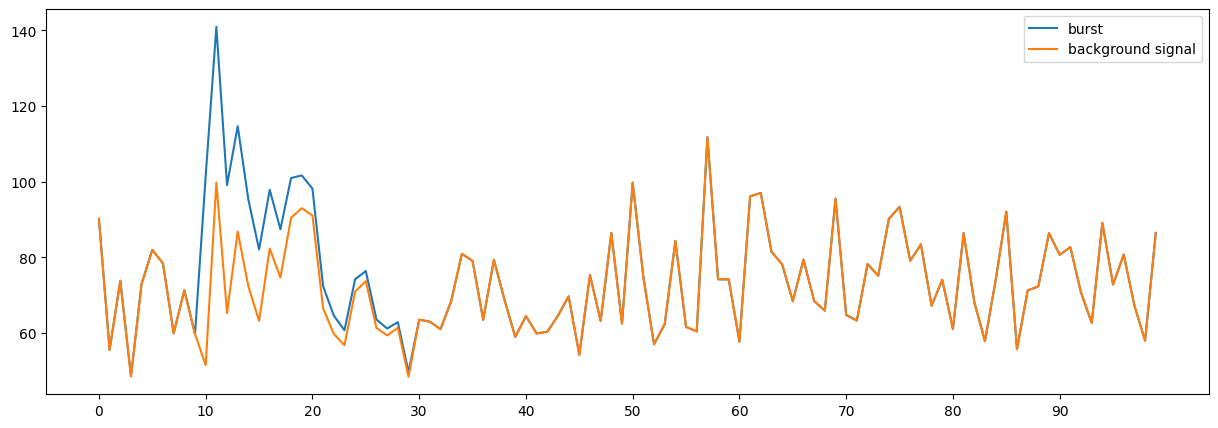

In [6]:
# 3.1) Plot both signals
i = np.random.randint(num_chunks)

## add burst to bg signal
perturbed_data = val_data.copy()
amplitude = 50
lambd =  np.random.uniform(0.1, 0.2)
burst = amplitude * np.exp(-lambd * np.arange(burst_duration))
perturbed_data[i, peak_time:burst_duration + peak_time] += burst

## plot the original bg signal and the burst
plt.figure(figsize=(15, 5))
plt.plot(perturbed_data[i], label = "burst")
plt.plot(val_data[i], label = "background signal")
plt.xticks(np.arange(0, len(perturbed_data[i]), step=10))  # Ticks every 10 bins
plt.legend()
plt.show()

 3.2) Now we apply the perturbation to all the selected validation and test light curves.

In [7]:
## Select the percentage of anomalies
val_anomaly_perc = 0.10
test_anomaly_perc = 0.15

# Apply bursts
def add_burst(data, anomaly_indices, anomaly_percentage, amplitudes, peak_time, burst_duration):
  ## Parameters
  amplitude_lb = amplitudes["lb"]
  amplitude_ub = amplitudes["ub"]
  lambda_lb = 0.1
  lambda_ub = 0.2

  ## Apply anomalies only to a selected percentage of light curves
  perturbed_data = data.copy()
  for i in anomaly_indices:
      amplitude = np.random.randint(amplitude_lb, amplitude_ub)
      lambd = np.random.uniform(lambda_lb, lambda_ub)
      burst = amplitude * np.exp(-lambd * np.arange(burst_duration))
      perturbed_data[i, peak_time:burst_duration + peak_time] += burst  # Add the anomaly

  return perturbed_data, anomaly_indices

# Apply bursts to val and test sets
amplitudes = {"lb": 40, "ub": 60}
fixed_anomalies_idx = np.random.choice(num_chunks, size=int(test_anomaly_perc * num_chunks), replace=False)

val_data_perturbed, val_anomaly_indices = add_burst(
    val_data, fixed_anomalies_idx, val_anomaly_perc, amplitudes=amplitudes,
    peak_time=peak_time, burst_duration=burst_duration
    )
test_data_perturbed, test_anomaly_indices = add_burst (
    test_data, fixed_anomalies_idx, test_anomaly_perc, amplitudes=amplitudes,
    peak_time=peak_time, burst_duration=burst_duration
    )

## **Data analysis**

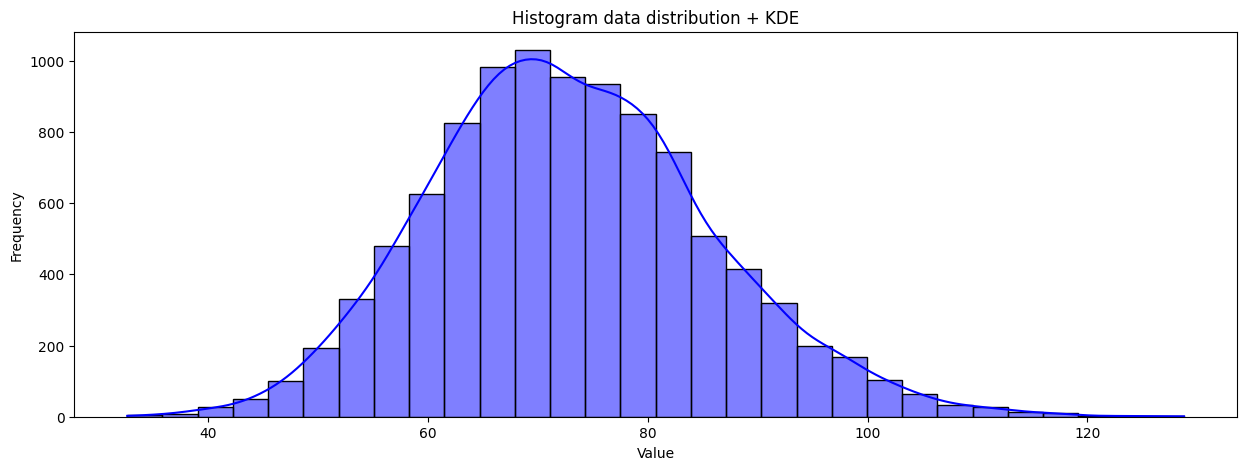

In [8]:
#@title Histogram plot to check the data distribution, that is a Skew-Normal
plt.figure(figsize=(15, 5))
sns.histplot(training_data_original, bins=30, kde=True, color="blue", alpha=0.5)
plt.title("Histogram data distribution + KDE")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

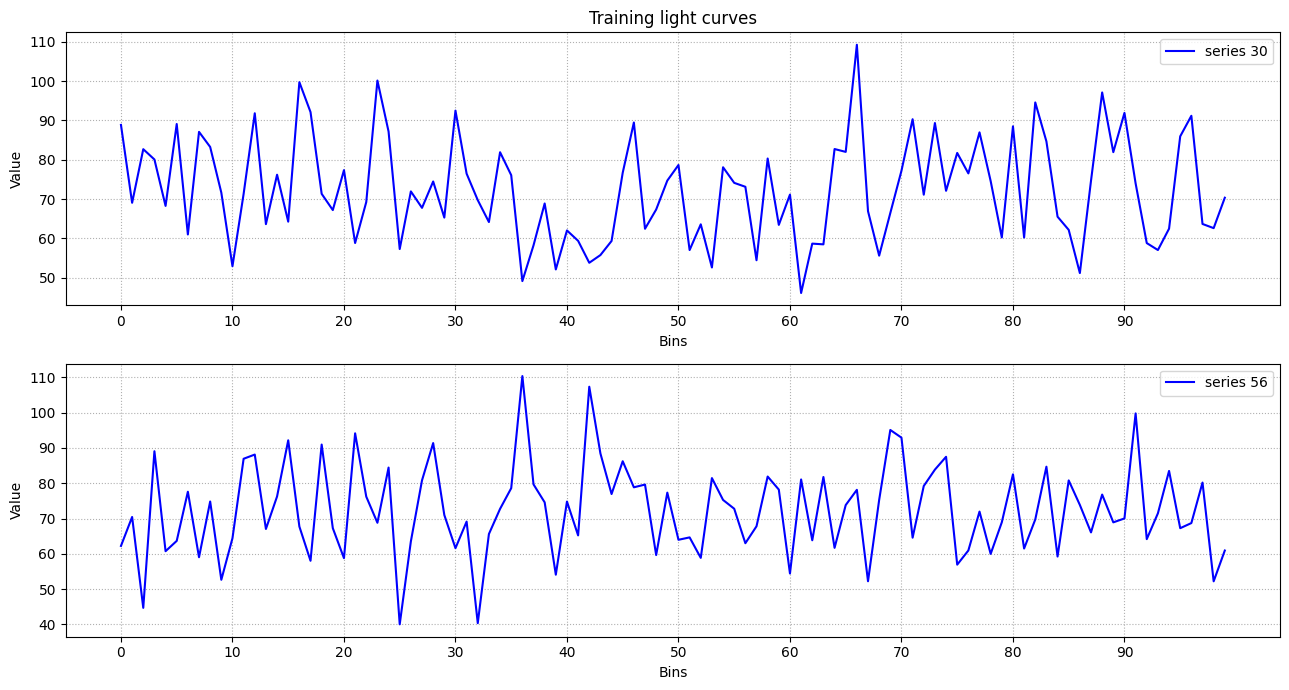

In [9]:
#@title Show training light curves, the background signals
show_lightcurves(training_data, num_chunks, chunk_size, "Training")

As said before, each of these light curves represents a background signal, therefore we can expect a "regular" behavior.

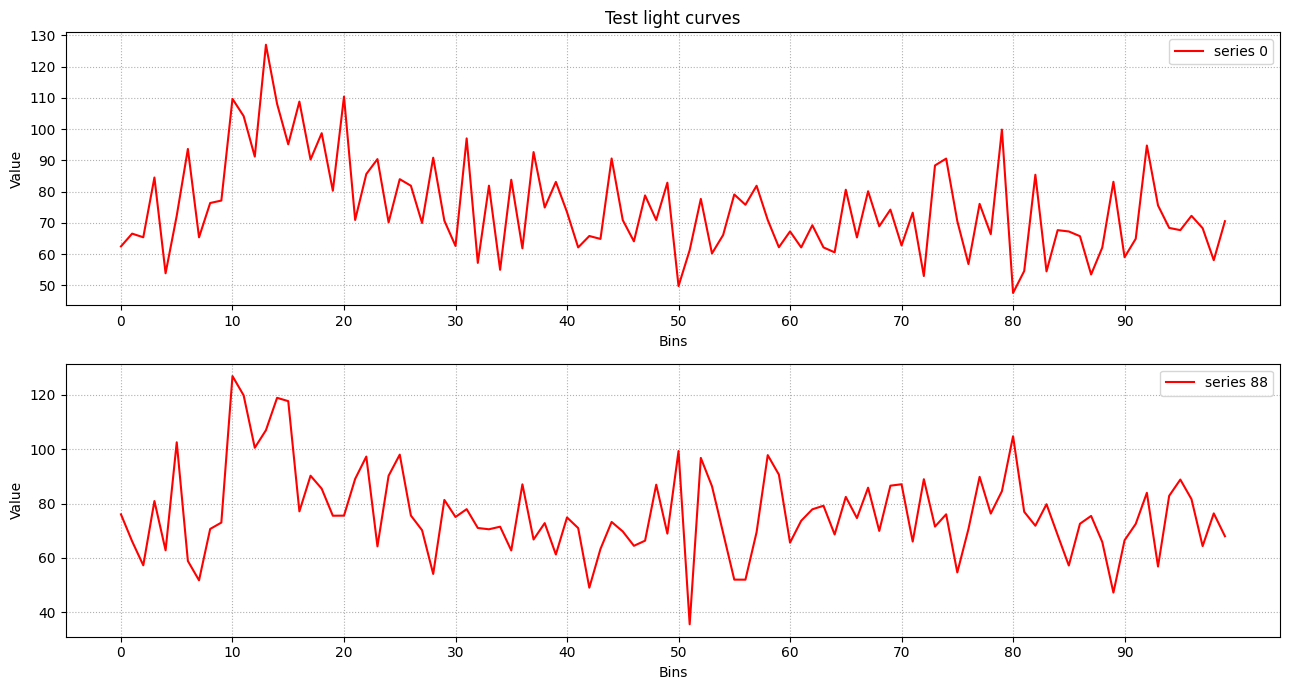

In [10]:
#@title Showing perturbed test lightcurves
show_lightcurves(test_data_perturbed, num_chunks, test_anomaly_indices, "Test", color = "red")

In [11]:
print(f"Real anomalies in test light curves: {np.sort(test_anomaly_indices)}")

Real anomalies in test light curves: [ 0 10 18 30 31 45 47 53 64 65 77 88 91 93 95]


As we can quite easily observe, both the validation and test light curves are slightly more pronounced around bin n.10, which presents a **peak** and a slight decay for a period of 20 bins.

## **Autoencodering**

We will train an autoencoder that will learn to reconstruct the original background signal. In this way, in the validation and test process, we will be able to detect potential anomalies if the reconstruction error is considerably higher than a certain threshold.

In particular, we will adopt a probabilistic approach instead: we will train for MLE for the current observations and we will learn the best params that maximize the likelihood of observing our input data. In particular, we will check if the predicted distribution, composed of mean, scale and skewness, aligns with the one of the test sample: the likelihood of observing the current sample given the predicted params and the learned distribution.

In [12]:
import keras
import tensorflow_probability as tfp
from scipy.optimize import root_scalar
from keras import layers, callbacks
from tensorflow.keras.utils import plot_model

In [13]:
#@title Normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_data = scaler.fit_transform(training_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)
val_data_perturbed = scaler.transform(val_data_perturbed)
test_data_perturbed = scaler.transform(test_data_perturbed)

### Custom Loss definition
We'll use a **Negative-Log-Likelihood** (NLL) for the Skew-Normal distribution. The model is learning to predict the best Skew-Normal distribution for each light curve. Namely, the AE learns to generate a probability distribution that represents the data, outputting its mean, variance and alpha value.

Basically, this loss function evaluates how likely each individual data point (from the input series) is under the predicted Skew-Normal distribution.

In [14]:
tfd = tfp.distributions

# Custom class definition
class SkewNormal(tfp.distributions.Distribution):
    def __init__(self, loc, scale, skewness, validate_args=False, allow_nan_stats=True, name="SkewNormal"):
        parameters = dict(locals())
        self.loc = tf.convert_to_tensor(loc, dtype=tf.float32)
        self.scale = tf.convert_to_tensor(scale, dtype=tf.float32)
        self.skewness = tf.convert_to_tensor(skewness, dtype=tf.float32)
        self.normal = tfd.Normal(loc=0.0, scale=1.0)  # Standard normal

        super(SkewNormal, self).__init__(
            dtype=tf.float32,
            reparameterization_type=tfd.NOT_REPARAMETERIZED,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            parameters=parameters,
            name=name.replace(" ", "_"),
        )

    # Log-probability density function (PDF) of the Skew-Normal distribution.
    def _log_prob(self, value):
        z = (value - self.loc) / self.scale
        normal_log_prob = self.normal.log_prob(z)
        skew_factor = 2 * self.normal.cdf(self.skewness * z)

        # Ensure numerical stability
        skew_factor = tf.clip_by_value(skew_factor, 1e-6, 1.0)  # Avoid log(0)
        return normal_log_prob + tf.math.log(skew_factor) - tf.math.log(self.scale)

In [15]:
# Negative Log-Likelihood for the Skew-Normal distribution.
def skew_normal_nll(y_true, params):
  mu, sigma, alpha = params[:, 0], params[:, 1], params[:, 2]

  # reshape to (batch_size, 1)
  mu = tf.expand_dims(mu, axis=-1)
  sigma = tf.expand_dims(sigma, axis=-1)
  alpha = tf.expand_dims(alpha, axis=-1)

  sn = SkewNormal(loc=mu, scale=sigma, skewness=alpha)
  return -tf.reduce_mean(sn.log_prob(y_true))

In [16]:
#@title Building the autoencoder
def build_autoencoder(input_shape, units=64):
  input_shape = (chunk_size, )
  input = keras.Input(shape = input_shape, dtype = "float32")

  latent = layers.Dense(units, activation = "relu")(input)
  mu = layers.Dense(1, activation = "linear")(latent)
  sigma = layers.Dense(1, activation = "softplus")(latent)
  alpha = layers.Dense(1, activation = "linear")(latent)

  output = layers.concatenate([mu, sigma, alpha], axis = 1)
  ae = keras.Model(input, output)

  return ae

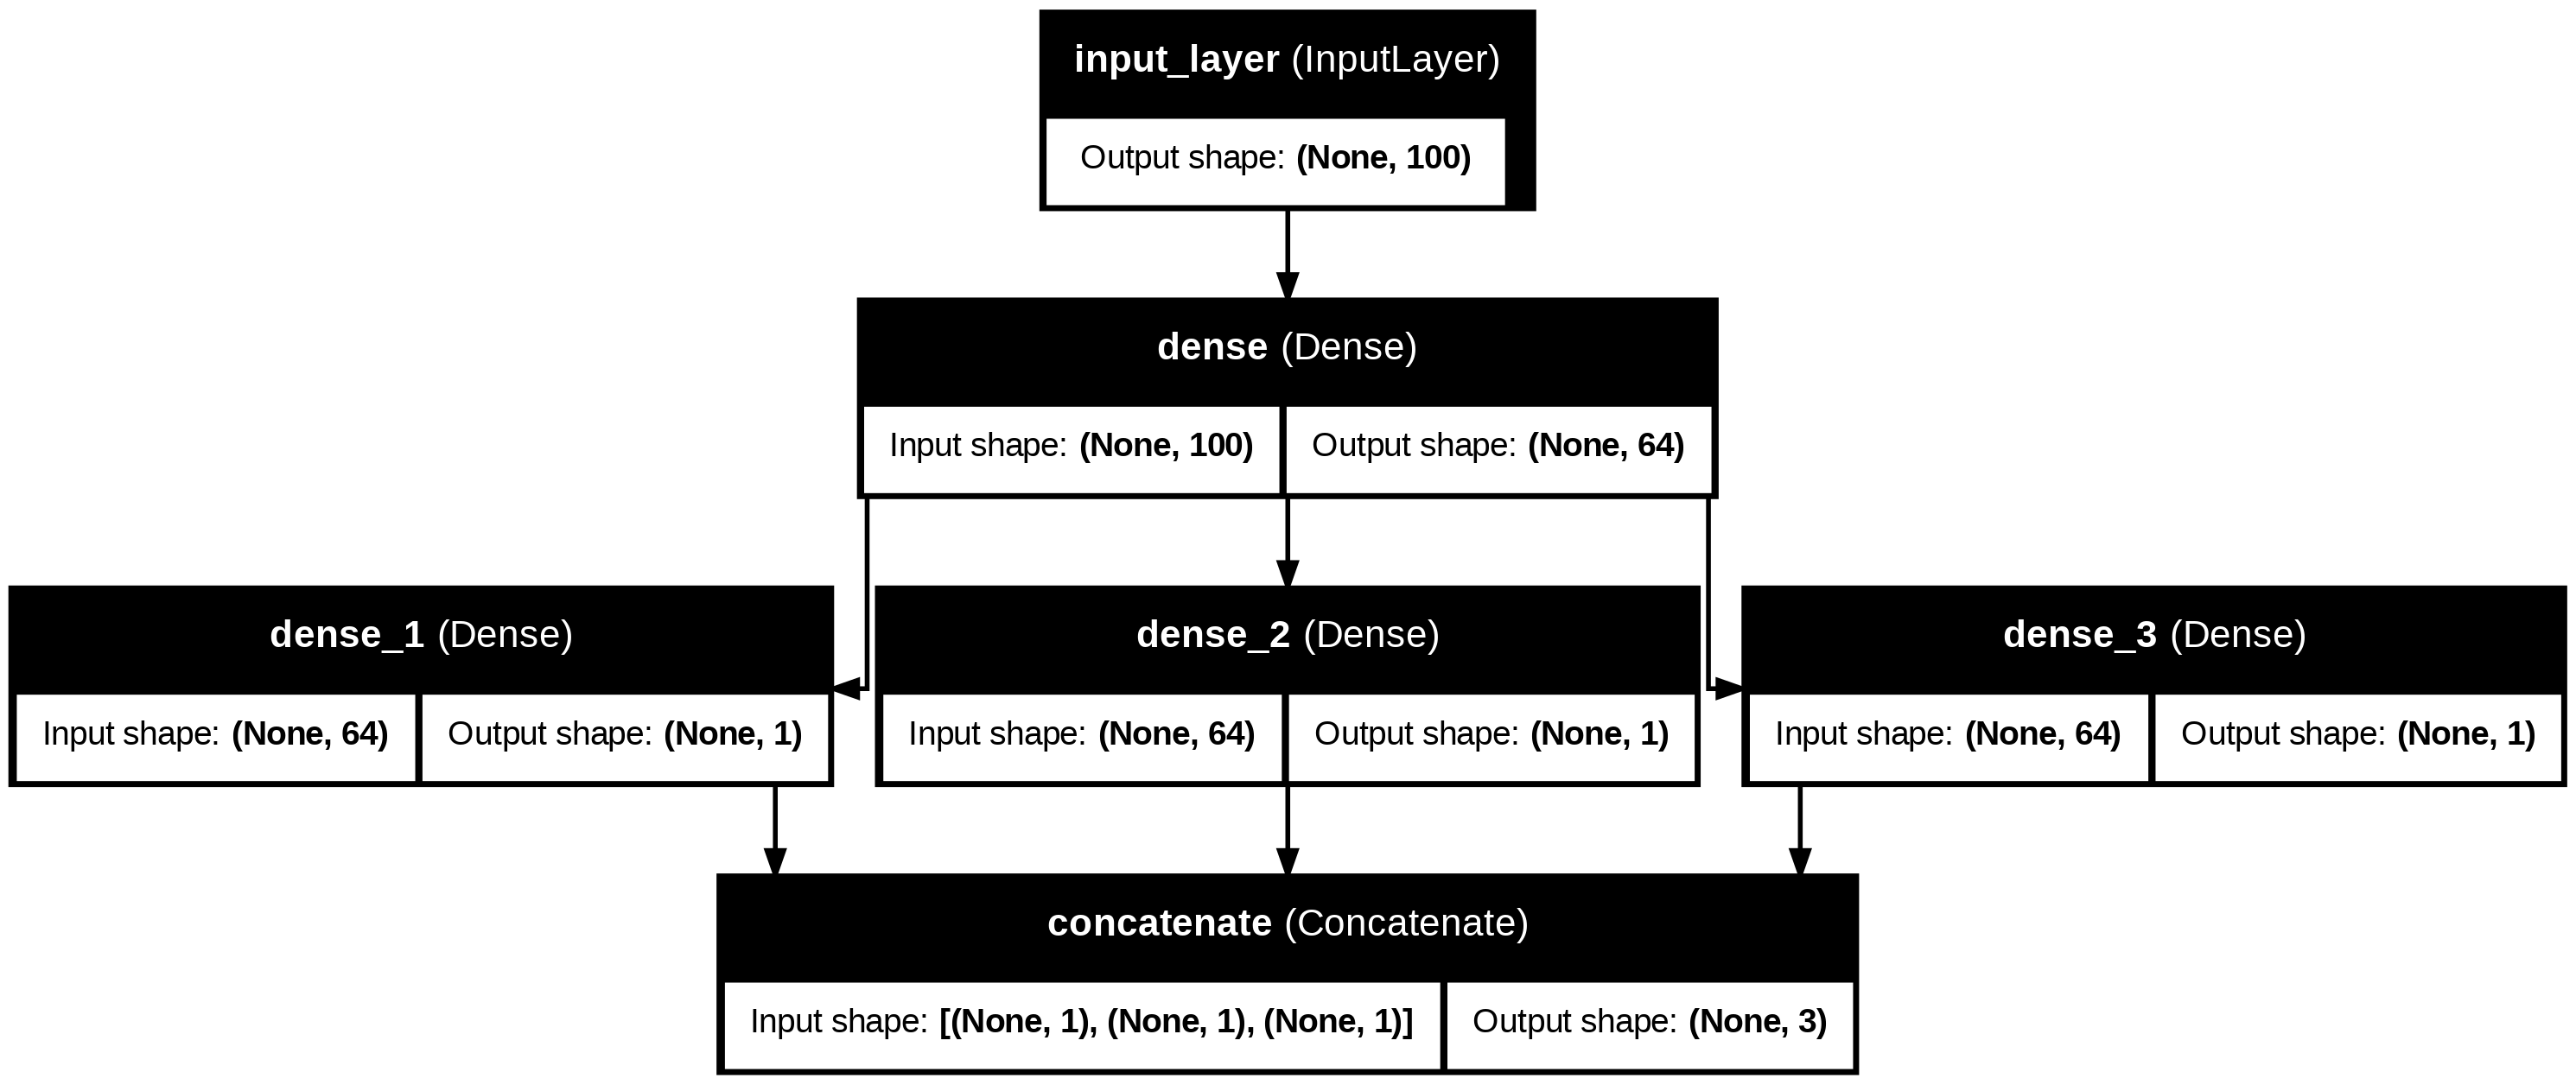

In [17]:
ae = build_autoencoder(input_shape = (chunk_size, ))
plot_model(ae, to_file="autoencoder_plot.png", show_shapes=True, show_layer_names=True)

In [18]:
ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      6,464 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3)         │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,659 (26.01 KB)

 Trainable params: 6,659 (26.01 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#@title Training
ae.compile(optimizer = "adam", loss = skew_normal_nll) # choose the custom loss
history = ae.fit(x = training_data, y = training_data, validation_data = (val_data_perturbed, val_data_perturbed), epochs = 50, batch_size = 16)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 13.3755 - val_loss: 5.7385
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.5872 - val_loss: 4.0182
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.3190 - val_loss: 3.1782
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.7116 - val_loss: 2.6974
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.3808 - val_loss: 2.4099
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.1897 - val_loss: 2.2323
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.0641 - val_loss: 2.1132
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.9749 - val_loss: 2.0288
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.9090 - val_loss: 1.9677
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.8597 - val_loss: 1.9212
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8211 - val_loss: 1.8851
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 1.7906 - val_loss: 1.8568

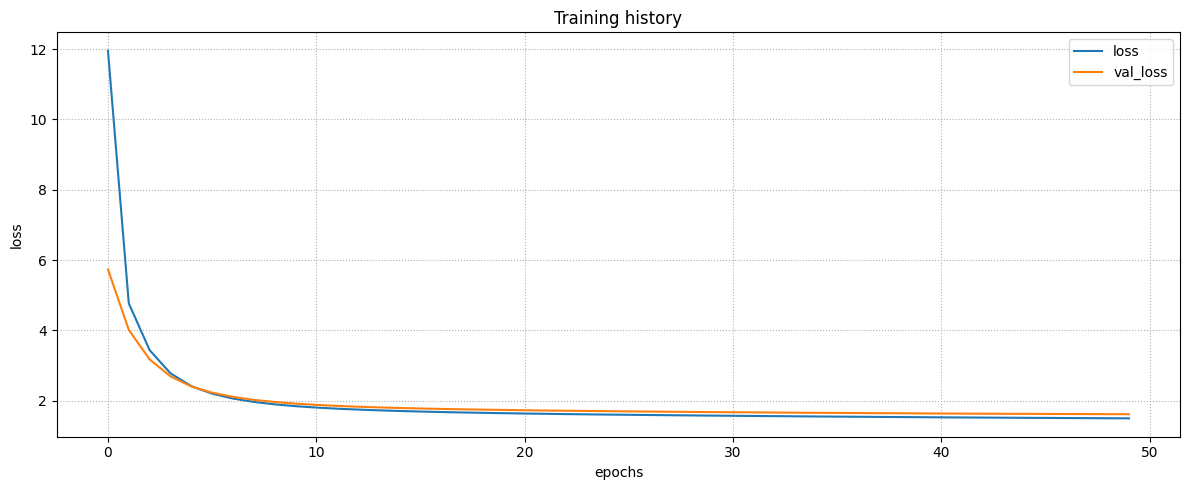

In [20]:
show_history(history)

#### Training results

In [21]:
mean_train_ll = history.history['loss'][-1]

print(f"Training loss: {mean_train_ll}")
print(f"Validation loss: {history.history['val_loss'][-1]}")

Training loss: 1.502935767173767
Validation loss: 1.6201930046081543


In [22]:
# Initialize a list to store the likelihoods of all training samples
train_likelihoods = []

# Loop through all training samples
for chunk in range(num_chunks):
    # Select the training sample
    test_sample = training_data[chunk]
    test_sample = np.expand_dims(test_sample, axis=0)

    # Predict the output using the trained model
    ae_output = ae.predict(test_sample, verbose=0)

    # Compute the likelihood for this sample using your skew_normal_nll function
    test_likelihood = skew_normal_nll(test_sample, ae_output)

    # Append the likelihood to the list
    train_likelihoods.append(test_likelihood)

# Convert the list to a numpy array for easier computation
train_likelihoods = np.array(train_likelihoods)

# Compute the standard deviation of the training likelihoods
stdev_train_ll = np.std(train_likelihoods)

# Print the standard deviation
print(f"Standard deviation of training likelihoods: {stdev_train_ll}")

Standard deviation of training likelihoods: 0.1260145753622055


#### Compute the fixed threshold, up to the 95th percentile, to determine anomalies

In [23]:
thresh_95 = np.percentile(train_likelihoods, 95)
print(f"95th Threshold: {thresh_95:.4f}")

95th Threshold: 1.7256


### **Evaluation**

In [24]:
# Generate test data
test_data = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples)
test_data, _ = reshape_data(test_data, chunk_size)

In this section, we will evaluate our model using different versions of the same perturbed test set, each with varying burst strengths. The goal is to find the optimal balance between:

* The **distinctiveness** of the background signal and the anomalous signals, ensuring that the test likelihood is sufficiently higher than the baseline, clearly reflecting the distinction between normal and anomalous signals.

* The **burst strength**, generating anomalies that are detectable but not overly obvious, preventing the anomalies from standing out too clearly.

In [25]:
def compute_likelihood(data, ae):
  likelihoods = []
  for chunk in range(num_chunks):
    sample = data[chunk]
    sample = np.expand_dims(sample, axis=0)
    ae_output = ae.predict(sample, verbose=0)
    likelihood = skew_normal_nll(sample, ae_output)
    likelihoods.append(likelihood)
  return likelihoods

Defining the dict for storing the results of the evaluation

In [26]:
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, classification_report,
    confusion_matrix, precision_score, recall_score
)

# Setting perturbation levels
burst_strengths = {
    "Weak": {"lb": 25,  "ub": 40},
    "Medium": {"lb": 40, "ub": 60},
    "Strong": {"lb": 60, "ub": 80},
    "Very strong": {"lb": 80, "ub": 100}
}

# Results dict.
results = {label: {
    "Avg_ll": None, "Std dev": None, "AUC": None,
    "Precision": None, "Recall": None, "F1": None,
    "Best Threshold (F1)": None
} for label in burst_strengths.keys()}

Let's evaluate and plot the performances of the model for each of the validation set version, for each of the chosen metrics:


*   ROC curve
*   AUC
*   Precision-Recall curve
*   F1-score



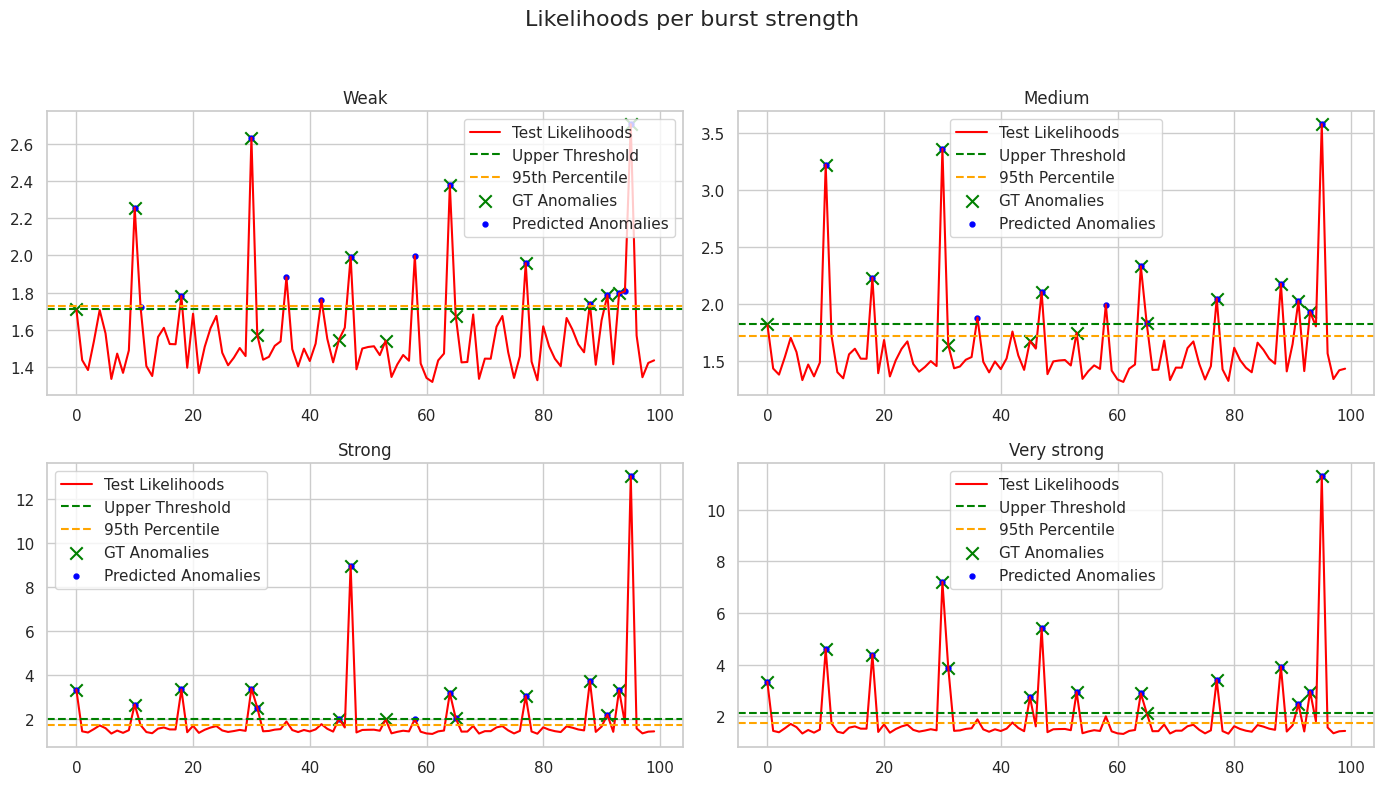

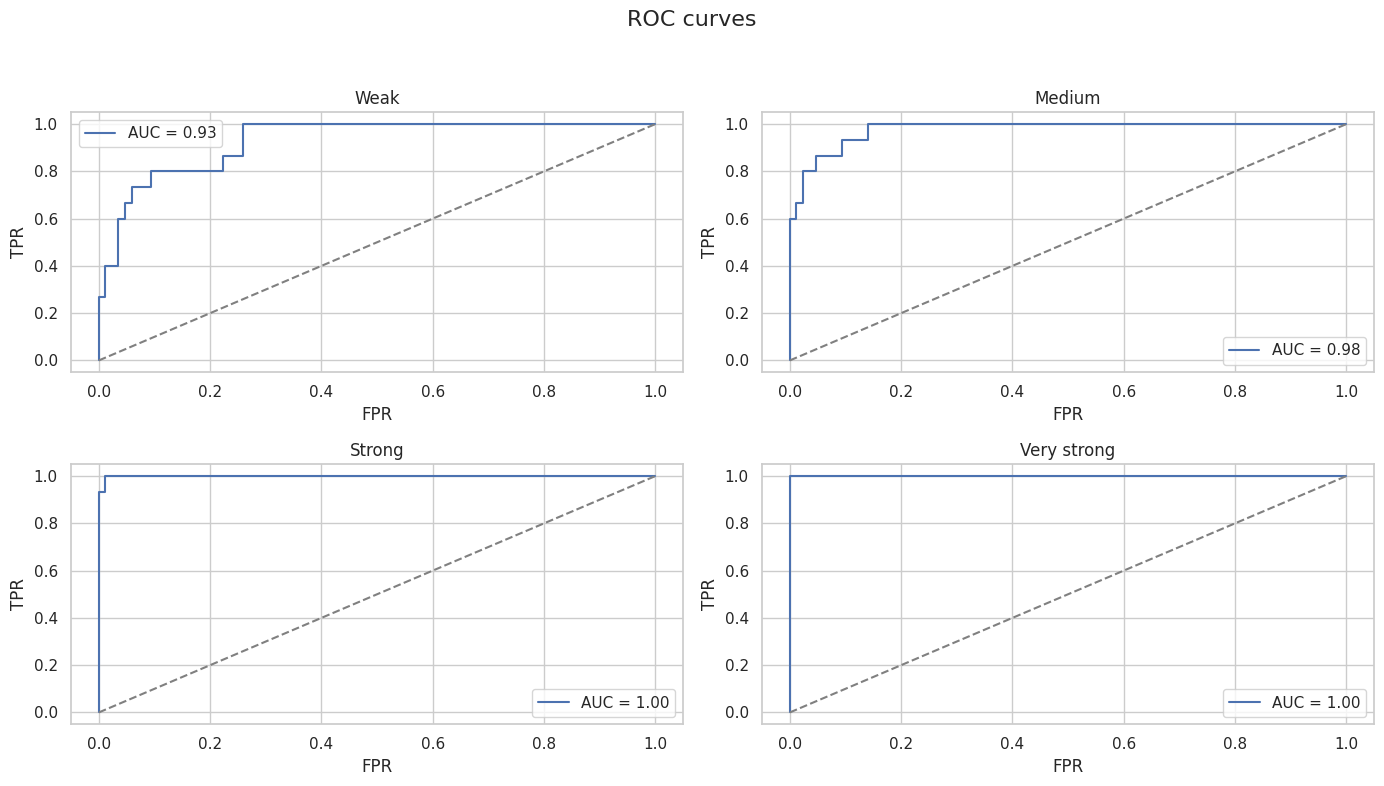

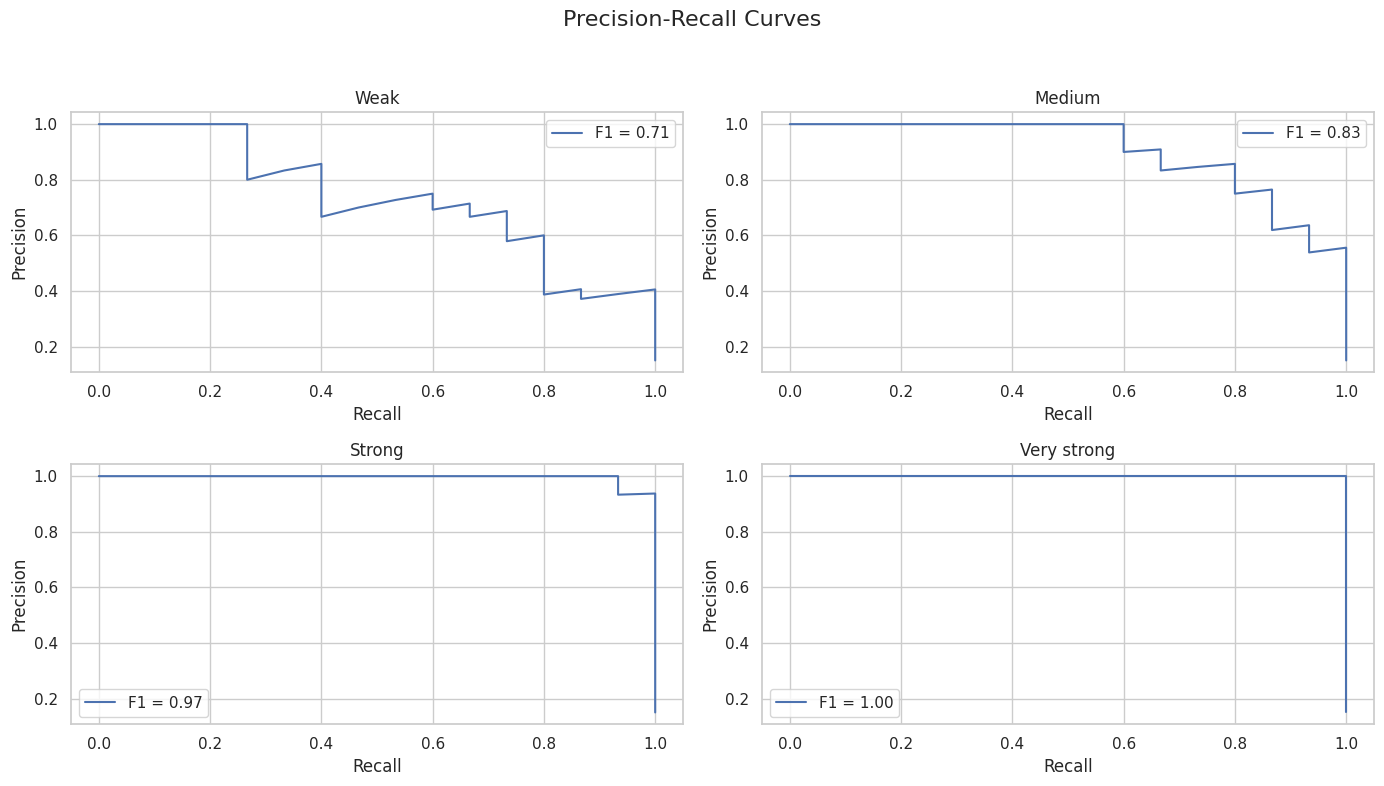

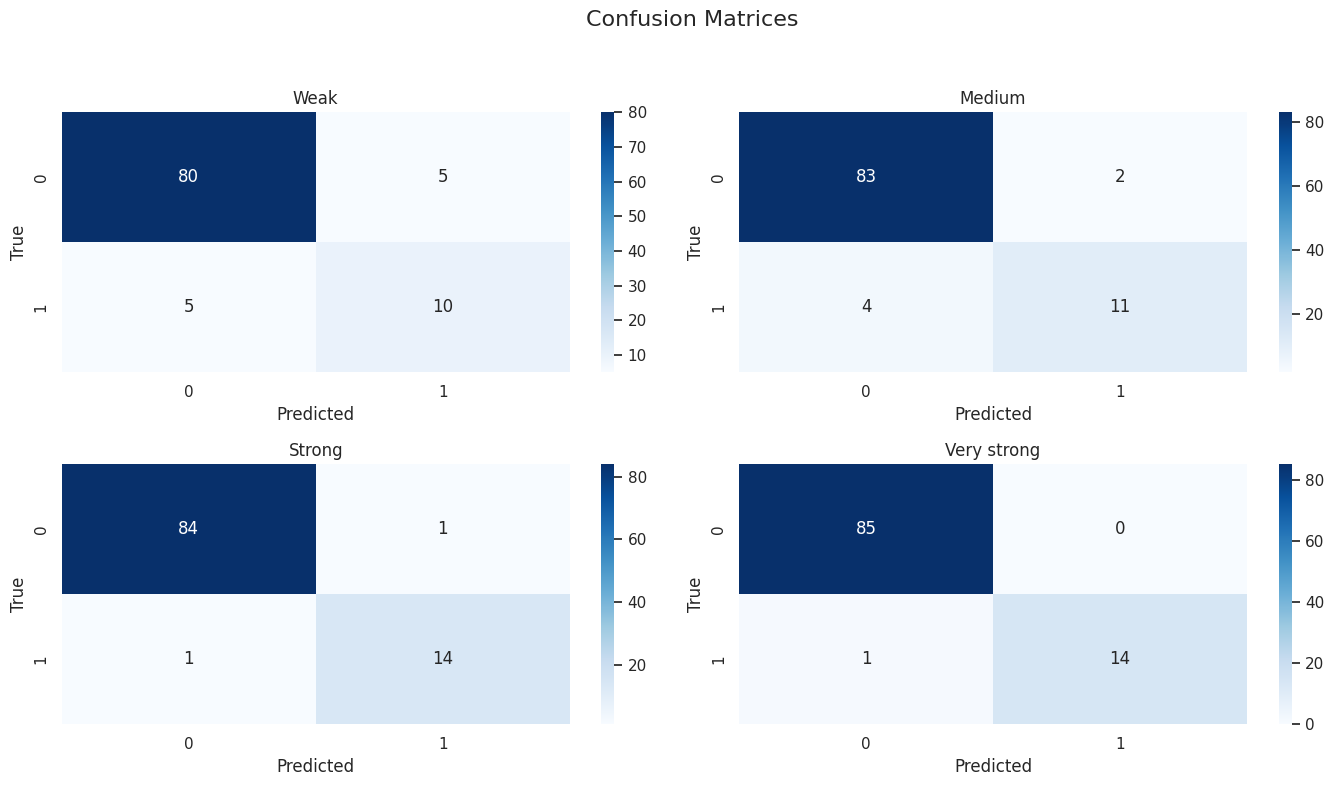

In [27]:
results = evaluate_and_plot_per_strength(
    test_data, results, fixed_anomalies_idx, test_anomaly_perc,
    burst_strengths, scaler, compute_likelihood, ae, train_likelihoods,
    num_chunks, thresh_95, peak_time, burst_duration
)

In [28]:
# Showing results
df_results = pd.DataFrame(results).T
print(df_results.round(4))

             Avg_ll  Std dev     AUC  Precision  Recall      F1  \
Weak         1.5655   0.2423  0.9286     0.6667  0.6667  0.7097   
Medium       1.6123   0.3746  0.9773     0.8462  0.7333  0.8276   
Strong       1.8608   1.4269  0.9992     0.9333  0.9333  0.9677   
Very strong  1.9105   1.3183  1.0000     1.0000  0.9333  1.0000   

             Best Threshold (F1)  
Weak                      1.7110  
Medium                    1.8258  
Strong                    1.9795  
Very strong               2.1301  


#### Choose a burst strength level
For final evaluation, we adopt a medium-strength perturbation level as our test condition. This level offers a trade-off between anomaly detectability and realism, allowing us to assess performance under the previous conditions.

In [ ]:
# Choose perturbation level
strength_lvl = "Medium"

In [ ]:
# TODO: format code

Ground truth anomalies: [ 0 10 18 30 31 45 47 53 64 65 77 88 91 93 95]
Detected (best F1): [ 0 10 18 30 36 47 53 58 64 65 77 88 91 93 95]
Detected (95th percentile): [ 0 10 18 30 31 36 42 45 47 53 58 64 65 77 88 91 93 94 95]


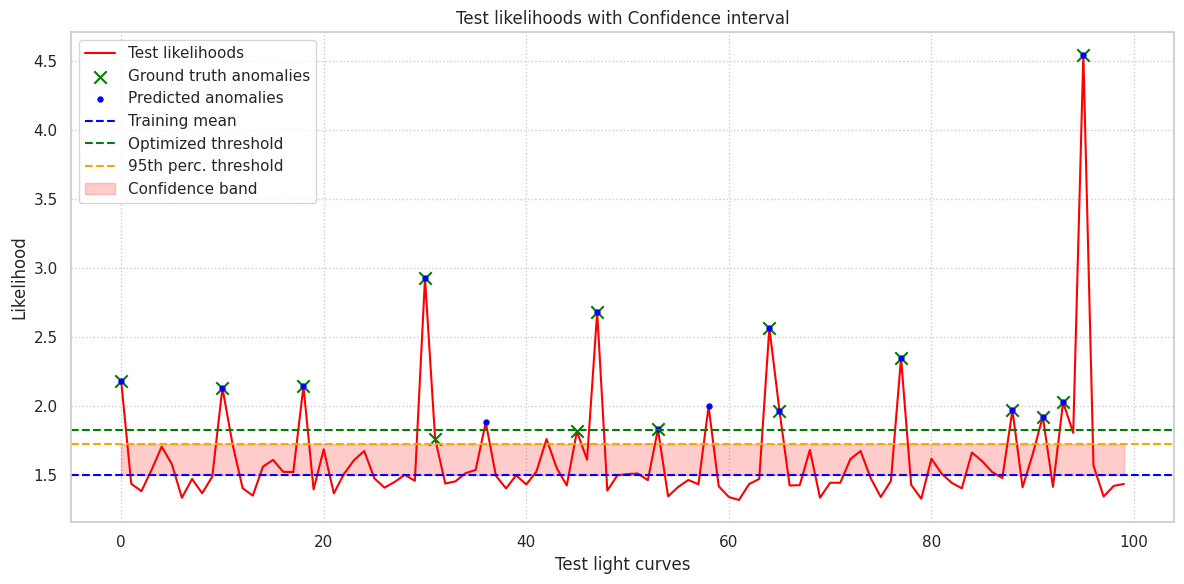


== Classification Report (F1 Threshold) ==
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        85
         1.0       0.87      0.87      0.87        15

    accuracy                           0.96       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.96      0.96      0.96       100

== Classification Report (95th Percentile) ==
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98        85
         1.0       0.79      1.00      0.88        15

    accuracy                           0.96       100
   macro avg       0.89      0.98      0.93       100
weighted avg       0.97      0.96      0.96       100



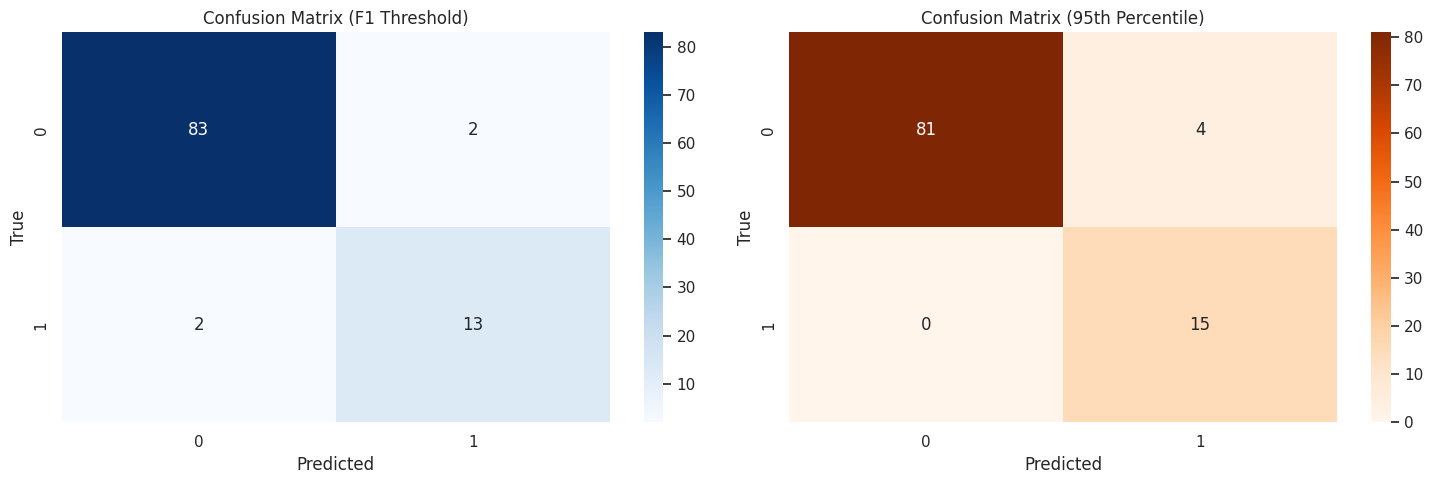

In [32]:
# Generate a new test set
test_data = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples)
test_data, _ = reshape_data(test_data, chunk_size)

# Perturbing
amplitudes = burst_strengths[strength_lvl]
test_data_perturbed, test_anomaly_indices = add_burst(
    test_data, fixed_anomalies_idx, test_anomaly_perc, amplitudes,
    peak_time, burst_duration
)
test_data_perturbed = scaler.transform(test_data_perturbed)

# Likelihoods
likelihoods = compute_likelihood(test_data_perturbed, ae)
avg_ll, std_ll = np.mean(likelihoods), np.std(likelihoods)

# Ground truth and scores
y_true = np.zeros(num_chunks)
y_true[test_anomaly_indices] = 1
y_scores = np.array(likelihoods)

# ROC & AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

# Precision-Recall & F1
precision, recall, pr_thresh = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Retrieving best threshold for the selected perturbation lvl
best_threshold = results[strength_lvl]["Best Threshold (F1)"]

# Predictions
y_pred_f1 = (y_scores > best_threshold).astype(int)
y_pred_95 = (y_scores > thresh_95).astype(int)

# Confusion Matrices
cm_f1 = confusion_matrix(y_true, y_pred_f1)
cm_95 = confusion_matrix(y_true, y_pred_95)

# Print anomalous indices
anomalous_indices_f1 = np.where(y_scores > best_threshold)[0]
anomalous_indices_95 = np.where(y_scores > thresh_95)[0]
print(f"Ground truth anomalies: {np.sort(test_anomaly_indices)}")
print(f"Detected (best F1): {np.sort(anomalous_indices_f1)}")
print(f"Detected (95th percentile): {np.sort(anomalous_indices_95)}")

# Plot likelihoods
plot_lls_anomalies(likelihoods, mean_train_ll, test_anomaly_indices,
                   anomalous_indices_f1, best_threshold, thresh_95)

# Print classification reports
print("\n== Classification Report (F1 Threshold) ==")
print(classification_report(y_true, y_pred_f1))
print("== Classification Report (95th Percentile) ==")
print(classification_report(y_true, y_pred_95))

# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(cm_f1, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix (F1 Threshold)")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

sns.heatmap(cm_95, annot=True, fmt='d', cmap='Oranges', ax=axs[1])
axs[1].set_title("Confusion Matrix (95th Percentile)")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

plt.tight_layout()
plt.show()

#### ROC curve

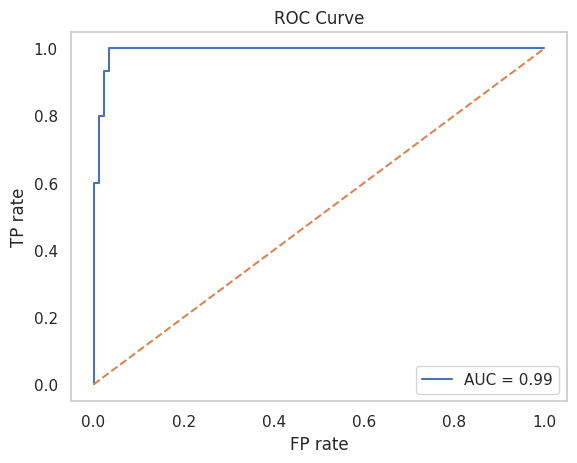

In [33]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

# Plot ROC
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("FP rate")
plt.ylabel("TP rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

#### PR curve

Best threshold (based on F1-score): 1.7632
Best F1-score: 0.9091


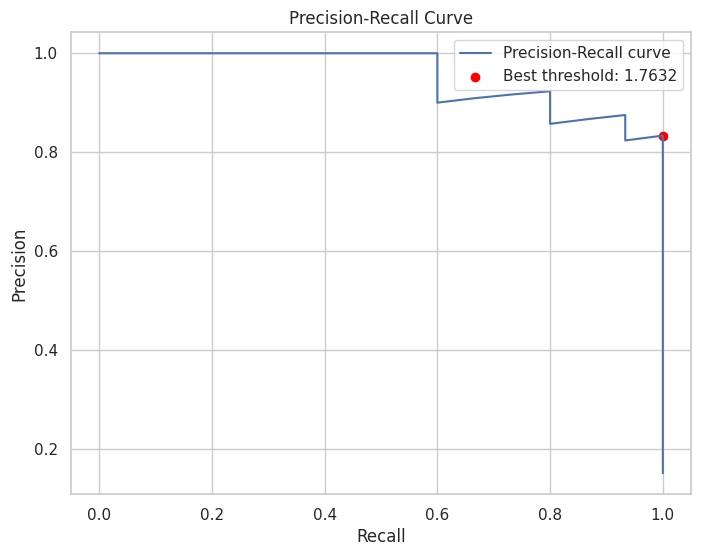

In [34]:
# Compute precision-recall
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes the F1-Score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f"Best threshold (based on F1-score): {best_threshold:.4f}")
print(f"Best F1-score: {best_f1_score:.4f}")

# Plot Precision-Recall curve and mark the best threshold
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.scatter(recall[best_threshold_index], precision[best_threshold_index], color='red', label=f"Best threshold: {best_threshold:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## Considerations

In [ ]:
# TODO